In [330]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from src.utilsRatings import *

# plots
from matplotlib import pyplot as plt
import plotly.graph_objects as go

%reload_ext autoreload
%autoreload 2

## Genres

### Load data

In [331]:
# Load data
processed_movies_df = pd.read_csv("data/processed_movies.csv")
movies_df = processed_movies_df[['Movie name', 'Movie release date', 'Movie genres']]

#### Add a "Periods" column

In [332]:
periods_map = { 
    "The Belle Époque (1900-1914)": {"start_year": 1900, "end_year": 1913}, 
    "World War I (1914-1918)": {"start_year": 1914, "end_year": 1919}, 
    "The Roaring Twenties (1920-1929)": {"start_year": 1920, "end_year": 1928}, 
    "The Great Depression (1929-1939)": {"start_year": 1929, "end_year": 1939}, 
    "World War II (1939-1945)": {"start_year": 1940, "end_year": 1946}, 
    "Early Cold War (1947-1960)": {"start_year": 1947, "end_year": 1960}, 
    "The Civil Rights Movement (1960-1970)": {"start_year": 1961, "end_year": 1970}, 
    "Late Cold War (1971-1991)": {"start_year": 1971, "end_year": 1991}, 
    "Post-Cold War and the New World Order (1992-2001)": {"start_year": 1992, "end_year": 2000}, 
    "War on Terrorism (2001-present)": {"start_year": 2001, "end_year": 2024}, 
}

def map_year_to_periods(year, periods):
    matching_periods = []
    for period, years in periods.items():
        if years['start_year'] <= year <= years['end_year']:
            matching_periods.append(period)
    if matching_periods:
        return matching_periods
    else:
        return ["Year not in any defined period"]
    
# Sort the periods based on their start year
sorted_periods = sorted(periods_map.items(), key=lambda x: x[1]['start_year'])

# Create a mapping from period name to its position in the timeline
period_order_map_dict = {period[0]: idx for idx, period in enumerate(sorted_periods)}

In [333]:
movies_df_copy = movies_df.copy()
movies_df_copy.loc[:, 'Periods'] = movies_df_copy['Movie release date'].apply(map_year_to_periods, periods=periods_map)

movies_df_copy['Periods'].head(5)

0                    [War on Terrorism (2001-present)]
1    [Post-Cold War and the New World Order (1992-2...
2                       [The Belle Époque (1900-1914)]
3                   [The Great Depression (1929-1939)]
4                   [The Great Depression (1929-1939)]
Name: Periods, dtype: object

#### Process the "Movie genres" column

- casefold
- transform the string into a list of strings (1 string = 1 genre)


In [334]:
# Casefolding all the strings of column "Movie genres" the Data Frame
movies_df_copy['Movie genres'] = movies_df_copy['Movie genres'].apply(lambda x: x.casefold() if isinstance(x, str) else x)

# Transform string into a list of strings (word = genre)
def clean_genres(x):
    # If the value is a string (which contains the genres), clean it
    if isinstance(x, str):
        str_to_list = [genre.strip("'") for genre in x.strip("[]").split(", ")]
        #str_to_list = [genre for genre in str_to_list if genre not in unwanted_genres]
        return str_to_list if str_to_list else None
    # If it's already a list, return it as is
    elif isinstance(x, list):
        return x
    else:
        genres = []
    # Remove the row if the list is empty
    return genres if genres else None


# Clean the genres
movies_df_copy['Movie genres'] = movies_df_copy['Movie genres'].apply(clean_genres)
movies_df_copy['Movie genres'].head(5)

0    [thriller, science fiction, horror, adventure,...
1     [mystery, biographical film, drama, crime drama]
2    [short film, silent film, indie, black-and-whi...
3                   [musical, comedy, black-and-white]
4                             [drama, black-and-white]
Name: Movie genres, dtype: object

#### Print the frequency of each genre

This helps identify the most common genres, providing insight for deciding how to group them later.

In [335]:
# This cell is just useful to rank the occurences of the genres
unique_genres = [genre for sublist in movies_df_copy['Movie genres'] for genre in sublist]

themes_counts_years = Counter(unique_genres)

# Sort the Counter dictionary by value in descending order
sorted_genre_counts = dict(sorted(themes_counts_years.items(), key=lambda item: item[1], reverse=True))

print(sorted_genre_counts)

{'drama': 12995, 'comedy': 9472, 'black-and-white': 6018, 'indie': 5413, 'thriller': 4851, 'short film': 4688, 'action': 4446, 'romance film': 4439, 'crime fiction': 3571, 'silent film': 3240, 'action/adventure': 3077, 'adventure': 2986, 'horror': 2965, 'documentary': 2702, 'family film': 2626, 'science fiction': 1885, 'western': 1824, 'mystery': 1816, 'romantic comedy': 1791, 'musical': 1678, 'animation': 1632, 'crime thriller': 1459, 'fantasy': 1422, 'romantic drama': 1407, 'war film': 1198, 'film adaptation': 1131, 'comedy-drama': 1066, 'period piece': 1037, 'biography': 959, 'comedy film': 940, 'psychological thriller': 931, 'sports': 806, 'teen': 789, 'television movie': 779, 'parody': 754, '"children\'s/family"': 733, 'black comedy': 667, 'family drama': 633, 'biographical film': 608, 'cult': 605, 'slasher': 598, 'suspense': 597, 'lgbt': 597, 'coming of age': 588, 'music': 573, 'film noir': 541, 'slapstick': 529, 'culture & society': 509, 'melodrama': 463, 'history': 454, 'supern

### Add a "Themes" column

- creation of 13 themes: Action/Adventure/Thriller, Comedy, Drama/Mystery, Romance, Horror/Crime, Science Fiction/Fantasy, Animation/Family, Historical/Biographical/Documentary, Short/Silent, Black-and-White, Independent/Experimental/LGBT, Musical, and Other.
- genres are mapped to one or several themes among the 13.

In [336]:
# Clearer to put it this way: theme and its corresponding genres
theme_mapping = {
    'Action/Adventure/Thriller': ['action', 'thriller', 'adventure', 'fantasy adventure', 'action comedy', 'action thrillers', 'spy', 'martial arts film', 'epic', 'road movie', 'action/adventure', 'adventure comedy', 'war film', 'military drama', 'combat film', 'anti-war film', 'political thriller', 'war film', 'military drama', 'combat film', 'western'],
    'Comedy': ['comedy', 'romantic comedy', 'black comedy', 'slapstick', 'comedy-drama', 'comedy film', 'adventure comedy', 'screwball comedy', 'fantasy comedy', 'domestic comedy', 'comedy of manners', 'sex comedy', 'comedy of errors'],
    'Drama/Mystery': ['drama', 'family drama', 'melodrama', 'crime drama', 'political drama', 'comedy-drama', 'marriage drama', 'courtroom drama', 'historical fiction', 'political cinema', 'social issues', 'crime comedy', 'mystery', 'detective', 'detective fiction'],
    'Romance': ['romance film', 'romantic comedy', 'romantic drama', 'romantic fantasy'],
    'Horror/Crime': ['crime fiction', 'crime thriller', 'gangster film', 'detective', 'detective fiction', 'crime drama', 'b-movie', 'heist', 'horror', 'slasher', 'psychological thriller', 'zombie film', 'horror comedy', 'monster movie', 'natural horror films', 'suspense'],
    'Science Fiction/Fantasy': ['science fiction', 'fantasy', 'superhero movie', 'sci-fi horror', 'superhero', 'fantasy comedy'],
    'Animation/Family': ['animation', 'animated cartoon', 'computer animation', 'animated musical', 'family', 'teen', '"children\'s/family"', '"children\'s"', 'family-oriented adventure', "children\'s fantasy"],
    'Historical/Biographical/Documentary': ['documentary', 'docudrama', 'rockumentary', 'concert film', 'mockumentary', 'period piece', 'historical drama', 'biography', 'history', 'biographical film', 'historical fiction'],
    'Short/Silent': ['short film', 'silent film'],
    'Black-and-White': ['black-and-white'], 
    'Indie/Experimental/LGBT': ['indie', 'experimental film', 'lgbt', 'gay', 'gay themed', 'gay interest'],
    'Musical': ['musical', 'musical drama', 'musical comedy'],
    'Other': []
}

# Inverting the theme_mapping to map genres to themes
genre_to_theme_mapping = {
    genre: theme
    for theme, genres in theme_mapping.items()
    for genre in genres
}

# Function to map genres to themes
def map_genres_to_themes(genres, mapping):
    if isinstance(genres, list):
        themes = set()
        for genre in genres:
            if genre in mapping:
                themes.add(mapping[genre])
            else:
                themes.add('Other')
        return themes
    elif isinstance(genres, str):
        if genres in mapping:
            return {mapping[genres]}
        else:
            return {'Other'}
    return None

movies_df_copy['Themes'] = movies_df_copy['Movie genres'].apply(lambda genres: map_genres_to_themes(genres, genre_to_theme_mapping))
movies_df_copy['Themes'].head(5)

0    {Horror/Crime, Action/Adventure/Thriller, Othe...
1    {Drama/Mystery, Horror/Crime, Historical/Biogr...
2    {Indie/Experimental/LGBT, Black-and-White, Com...
3                   {Black-and-White, Comedy, Musical}
4                     {Drama/Mystery, Black-and-White}
Name: Themes, dtype: object

### Plots

In [337]:
# Prepare the data for the plots
movies_df_copy_exploded = movies_df_copy.explode('Themes')

themes = list(theme_mapping.keys())

In [338]:
# Define a color palette for the themes so they are assigned the same color for all plots
custom_colors = [
    "#e41a1c",  # Red
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#ff7f00",  # Orange
    "#984ea3",  # Purple
    "#ffff33",  # Yellow
    "lime",
    "#000000",  # Black
    "#999999",  # Gray
    "pink",  # 
    "#c2c2f0",  # Lavender
    "blue",
    "#00ced1",  # Dark Turquoise
]

# Map themes to distinct colors
theme_colors = {theme: color for theme, color in zip(themes, custom_colors)}

#### Themes according to Years

In [339]:
themes_years_counts = (
    movies_df_copy_exploded
    .groupby(['Themes', 'Movie release date'])
    .size()
    .reset_index(name='count')
)

# Pivot the table so that each theme has its own column
theme_years_counts_pivot = themes_years_counts.pivot(index='Movie release date', columns='Themes', values='count')
theme_years_counts_pivot = theme_years_counts_pivot.fillna(0)

# Normalize the counts
normalized_theme_years_counts = theme_years_counts_pivot.div(theme_years_counts_pivot.sum(axis=1), axis=0)

#### Number of movies over the years

In [340]:
# Create an empty figure
fig = go.Figure()

# Add each theme as a trace
for theme in themes:
    if theme in theme_years_counts_pivot.columns:
        fig.add_trace(go.Scatter(
            x=theme_years_counts_pivot.index,  # x-axis is the release year
            y=theme_years_counts_pivot[theme],  # y-axis is the number of movies for each theme
            mode='lines',  # Use lines for the plot
            name=theme,  # Set the theme name for the legend
            line=dict(color=theme_colors.get(theme, 'gray')),  # Use color mapping for each theme
            hovertemplate='Year: %{x}<br>Number of Movies: %{y}<br>'  # Custom hover text
        ))

# Add buttons for hide/show functionality
visibility = [[True if i == idx else False for i in range(len(themes))]
              for idx in range(len(themes))]

# Define "Select Theme" button
select_theme_button = dict(
    label="Select Theme",  # Displayed as a label in the dropdown
    method=None,  # Non-interactive option
    args=[]  # No action associated with this
)

theme_buttons = [
    dict(
        label=theme,
        method="update",
        args=[
            {"visible": vis},  # Update visibility
            {"title": f"Evolution of {theme} Movies Over the Years"}  # Update title
        ]
    )
    for theme, vis in zip(themes, visibility)
]


# Combine "Select Theme" and theme-specific buttons
buttons = [select_theme_button] + theme_buttons

# Dropdown menu for individual themes
dropdown_menu = dict(
    type="dropdown",
    buttons=buttons,
    x=1.214,
    xanchor="center",
    y=1.11,
    yanchor="top",
)

# Button for "Show All" placed on the side
side_button = dict(
    type="buttons",
    buttons=[
        dict(
            label="Show All",
            method="update",
            args=[
                {"visible": [True] * len(themes)},
                {"title": "Evolution of Movie Themes Over the Years"}
            ]
        )
    ],
    x=1.005,  # Adjust position to place on the side
    xanchor="left",
    y=1.17,
    yanchor="middle",
)

# Update layout
fig.update_layout(
    updatemenus=[dropdown_menu, side_button],
    title={
        'text': 'Evolution of Movie Themes Over the Years',
        'x': 0.5,  # Center the title
        'xanchor': 'right'
    },
    title_x=0.5,
    barmode='stack',
    xaxis_title='Release Year',
    yaxis_title='Number of Movies',
    legend_title="Themes",
    height=500,
    width=1000,
)

# Show the interactive plot
fig.show()
fig.write_html('/Users/lilly-flore/Desktop/line_theme_year.html')

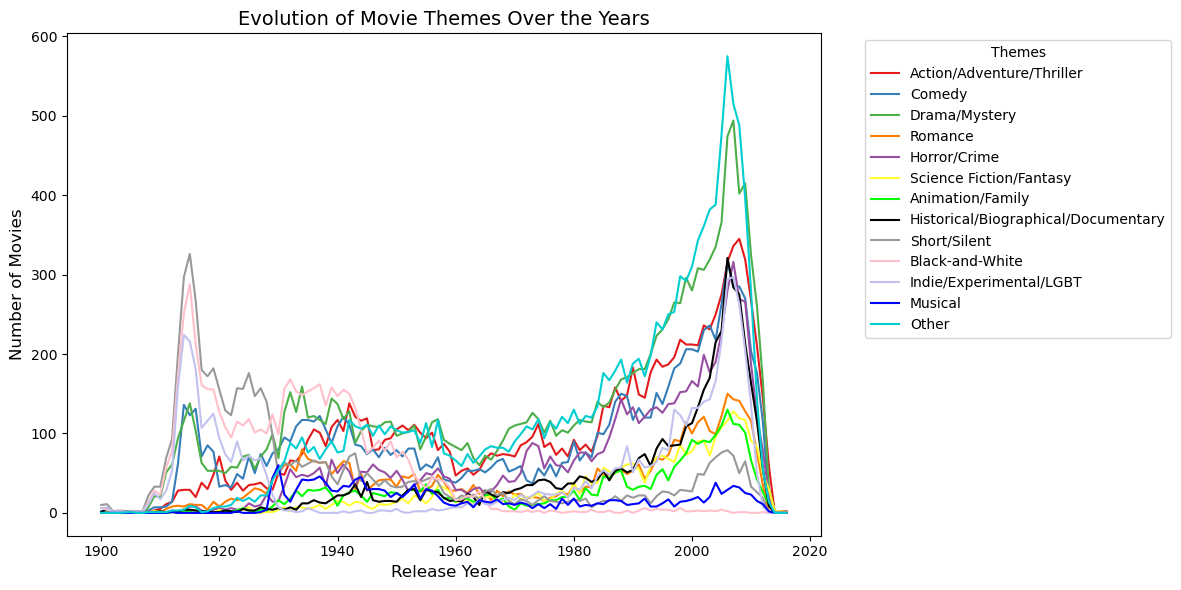

In [341]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Add each theme as a line
for theme in themes:
    if theme in theme_years_counts_pivot.columns:
        ax.plot(
            theme_years_counts_pivot.index,  # Years on the x-axis
            theme_years_counts_pivot[theme],  # Number of movies on the y-axis
            label=theme,  # Theme name for the legend
            color=theme_colors.get(theme, 'gray')  # Theme color
        )

# Add a title and axis labels
ax.set_title('Evolution of Movie Themes Over the Years', fontsize=14)
ax.set_xlabel('Release Year', fontsize=12)
ax.set_ylabel('Number of Movies', fontsize=12)

# Add a legend
ax.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust margins to properly display the legend
plt.tight_layout()

# Display the plot
plt.show()

#### Focus on the top firt and last 3 Themes from 1900 to nowadays

Identify the top 3 popular themes from the first and last 10 years of data and generates interactive plots showing the trends of these themes over time, with associated genres displayed on hover.

In [342]:
# First 3 most popular themes for the earliest years
start_years = theme_years_counts_pivot.iloc[:10] # based on the first 10 years
start_popular_themes = start_years.sum().nlargest(3).index

# First 3 most popular themes for the most recent years
end_years = theme_years_counts_pivot[theme_years_counts_pivot.columns.difference(['Other'])]
end_years = end_years.iloc[-10:] # based on the last 10 years
end_popular_themes = end_years.sum().nlargest(3).index

# Function to create a plot for selected themes
def create_theme_plot(themes, title):
    fig = go.Figure()

    for theme in themes:
        if theme in theme_years_counts_pivot.columns:
            # Get genres associated with the theme
            associated_genres = theme_mapping.get(theme, [])
            if len(associated_genres) > 5:
                genres_text = ', '.join(associated_genres[:5]) + ', ...'  # Truncate and add ellipsis
            else:
                genres_text = ', '.join(associated_genres)
            
            fig.add_trace(go.Scatter(
                x=theme_years_counts_pivot.index,
                y=theme_years_counts_pivot[theme],
                mode='lines',
                name=theme,
                line=dict(color=theme_colors.get(theme, 'gray')),
                hovertemplate=f'<b>Genres:</b> {genres_text}<br>'
                              f'<b>Year:</b> %{{x}}<br><b>Number of Movies:</b> %{{y}}<br>'
            ))

    fig.update_layout(
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title='Release Year',
        yaxis_title='Number of Movies',
        legend_title="Themes",
        height=400,
        width=600,
    )

    return fig

# Create plots
fig_start = create_theme_plot(start_popular_themes, "Top 3 Popular Themes in Early Years")
fig_end = create_theme_plot(end_popular_themes, "Top 3 Popular Themes in Recent Years")

# Show the plots
fig_start.show()
fig_end.show()
fig_start.write_html('/Users/lilly-flore/Desktop/line_start_3.html')
fig_end.write_html('/Users/lilly-flore/Desktop/line_end_3.html')

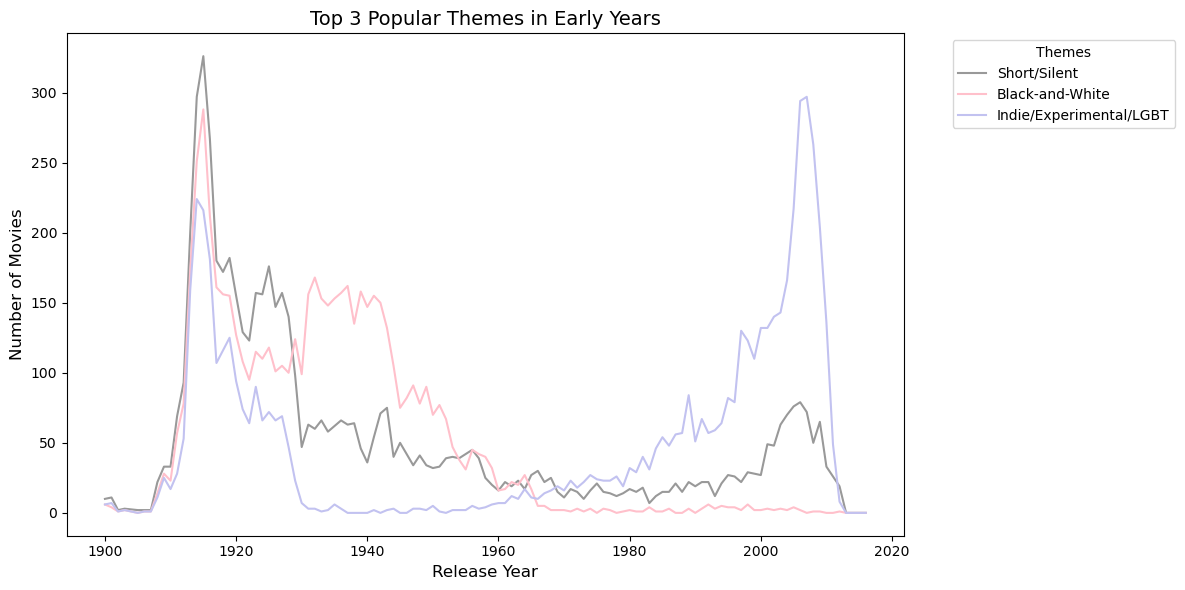

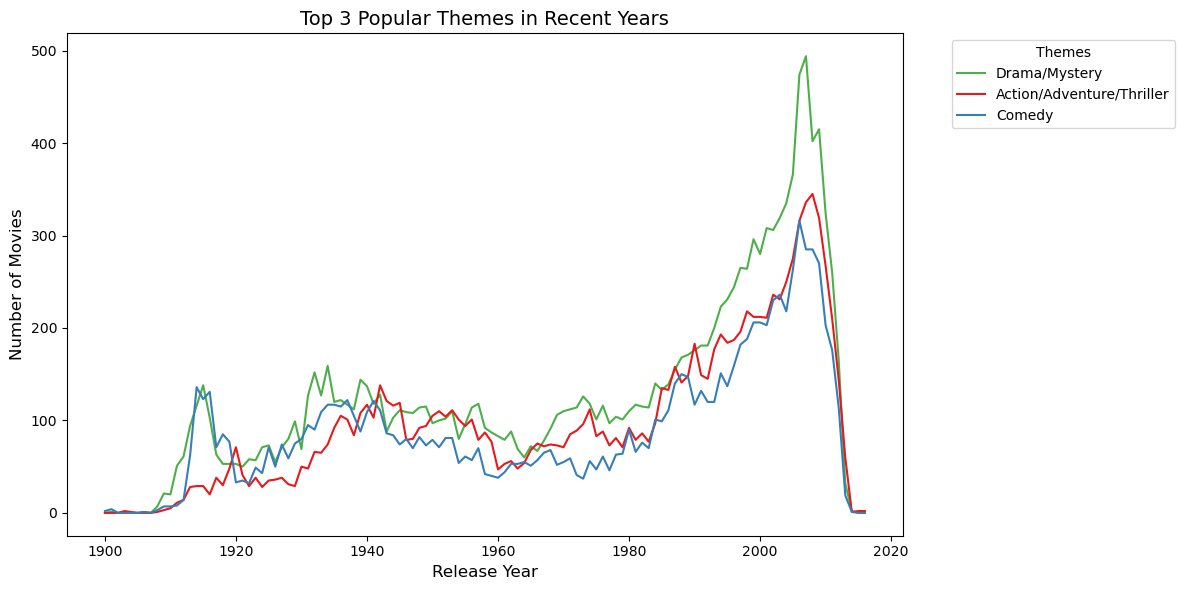

In [343]:
# Function to create a static plot for selected themes
def create_theme_plot_static(themes, title):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))

    for theme in themes:
        if theme in theme_years_counts_pivot.columns:
            # Plot each theme with a line
            ax.plot(
                theme_years_counts_pivot.index,  # Years on the x-axis
                theme_years_counts_pivot[theme],  # Number of movies on the y-axis
                label=theme,  # Theme name for the legend
                color=theme_colors.get(theme, 'gray')  # Theme color
            )

    # Add title and axis labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Release Year', fontsize=12)
    ax.set_ylabel('Number of Movies', fontsize=12)

    # Add legend
    ax.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust margins to display the legend correctly
    plt.tight_layout()

    return fig

# Create static plots for the earliest and most recent years
fig_start_static = create_theme_plot_static(start_popular_themes, "Top 3 Popular Themes in Early Years")
fig_end_static = create_theme_plot_static(end_popular_themes, "Top 3 Popular Themes in Recent Years")

# Save the static plots
fig_start_static.savefig('/Users/lilly-flore/Desktop/static_start_3.png', dpi=300)
fig_end_static.savefig('/Users/lilly-flore/Desktop/static_end_3.png', dpi=300)

# Show the static plots
plt.show()


#### Themes according to Periods

   - The `movies_df_copy_exploded` DataFrame is created by exploding the `'Periods'` column. This step is necessary since a single movie can belong to multiple periods, and we want to analyze each period separately.

   - We pivot the `themes_counts_periods` DataFrame using the `pivot()` method to create a table where each row represents a period, and each column represents a theme. The values in the table correspond to the count of movies for each theme and period combination.

   - The periods are sorted according to a predefined order stored in `period_order_map_dict`.

   - The pivot table is then normalized row-wise. For each period, the counts are divided by the sum of the counts in that row. The result is a table of percentages, where each value represents the proportion of movies for a particular theme in a given period.

In [344]:
movies_df_copy_exploded = movies_df_copy_exploded.explode('Periods')

themes_counts_periods = (
    movies_df_copy_exploded
    .groupby(['Themes', 'Periods'])
    .size()
    .reset_index(name='count')
)

# Pivot the table so that each theme has its own column
theme_periods_counts_pivot = themes_counts_periods.pivot(index='Periods', columns='Themes', values='count')

sorted_periods = sorted(period_order_map_dict.keys(), key=lambda x: period_order_map_dict[x])

# Reorder the index of the pivot table based on the sorted periods
theme_periods_counts_pivot = theme_periods_counts_pivot.loc[sorted_periods]
theme_periods_counts_pivot = theme_periods_counts_pivot.fillna(0)

# Normalize the counts row-wise to calculate percentages
normalized_theme_periods_counts = theme_periods_counts_pivot.div(theme_periods_counts_pivot.sum(axis=1), axis=0)

# Display the percentage pivot table
normalized_theme_periods_counts.head(5)

Themes                            Action/Adventure/Thriller  Animation/Family  \
Periods                                                                         
The Belle Époque (1900-1914)                       0.038050          0.002378   
World War I (1914-1918)                            0.038002          0.000784   
The Roaring Twenties (1920-1929)                   0.072216          0.005203   
The Great Depression (1929-1939)                   0.097834          0.028922   
World War II (1939-1945)                           0.144234          0.026555   

Themes                            Black-and-White    Comedy  Drama/Mystery  \
Periods                                                                      
The Belle Époque (1900-1914)             0.230678  0.064209       0.152200   
World War I (1914-1918)                  0.239569  0.122037       0.103036   
The Roaring Twenties (1920-1929)         0.203746  0.092820       0.118210   
The Great Depression (1929-1939)         0.191978  0.132468       0.160438   
World War II (1939-1945)                 0.153874  0.120953       0.144416   

Themes                            Historical/Biographical/Documentary  \
Periods                                                                 
The Belle Époque (1900-1914)                                 0.008323   
World War I (1914-1918)                                      0.003134   
The Roaring Twenties (1920-1929)                             0.006243   
The Great Depression (1929-1939)                             0.012735   
World War II (1939-1945)                                     0.032739   

Themes                            Horror/Crime  Indie/Experimental/LGBT  \
Periods                                                                   
The Belle Époque (1900-1914)          0.005945                 0.184899   
World War I (1914-1918)               0.005289                 0.189814   
The Roaring Twenties (1920-1929)      0.016233                 0.133611   
The Great Depression (1929-1939)      0.055225                 0.005713   
World War II (1939-1945)              0.065478                 0.001273   

Themes                             Musical     Other   Romance  \
Periods                                                          
The Belle Époque (1900-1914)      0.000595  0.006540  0.014863   
World War I (1914-1918)           0.000000  0.005681  0.011166   
The Roaring Twenties (1920-1929)  0.001457  0.028512  0.038293   
The Great Depression (1929-1939)  0.048441  0.097715  0.078315   
World War II (1939-1945)          0.043652  0.126228  0.059476   

Themes                            Science Fiction/Fantasy  Short/Silent  
Periods                                                                  
The Belle Époque (1900-1914)                     0.004756      0.286564  
World War I (1914-1918)                          0.002547      0.278942  
The Roaring Twenties (1920-1929)                 0.004579      0.278876  
The Great Depression (1929-1939)                 0.007736      0.082480  
World War II (1939-1945)                         0.014187      0.066933

Display the evolution of themes over the periods

In [345]:
# Create an empty figure
fig = go.Figure()

# Add each theme as a trace
for theme in themes:
    if theme in normalized_theme_periods_counts.columns:
        fig.add_trace(go.Scatter(
            x=normalized_theme_periods_counts.index,  # x-axis is the release year
            y=normalized_theme_periods_counts[theme],  # y-axis is the number of movies for each theme
            mode='lines',  # Use lines for the plot
            name=theme,  # Set the theme name for the legend
            line=dict(color=theme_colors.get(theme, 'gray')),  # Use color mapping for each theme
            hovertemplate='Year: %{x}<br>Number of Movies: %{y}<br>'  # Custom hover text
        ))

# Add buttons for hide/show functionality
visibility = [[True if i == idx else False for i in range(len(themes))]
              for idx in range(len(themes))]

# Define "Select Theme" button
select_theme_button = dict(
    label="Select Theme",  # Displayed as a label in the dropdown
    method=None,  # Non-interactive option
    args=[]  # No action associated with this
)

theme_buttons = [
    dict(
        label=theme,
        method="update",
        args=[
            {"visible": vis},  # Update visibility
            {"title": f"Evolution of {theme} Movies Over the Periods"}  # Update title
        ]
    )
    for theme, vis in zip(themes, visibility)
]


# Combine "Select Theme" and theme-specific buttons
buttons = [select_theme_button] + theme_buttons

# Dropdown menu for individual themes
dropdown_menu = dict(
    type="dropdown",
    buttons=buttons,
    x=1.214,
    xanchor="center",
    y=1.2,
    yanchor="top",
)

# Button for "Show All" placed on the side
side_button = dict(
    type="buttons",
    buttons=[
        dict(
            label="Show All",
            method="update",
            args=[
                {"visible": [True] * len(themes)},
                {"title": "Evolution of Movie Themes Over the Periods"}
            ]
        )
    ],
    x=1.005,  # Adjust position to place on the side
    xanchor="left",
    y=1.3,
    yanchor="middle",
)

# Update layout
fig.update_layout(
    updatemenus=[dropdown_menu, side_button],
    title={
        'text': 'Evolution of Movie Themes Over the Periods',
        'x': 0.5,  # Center the title
        'xanchor': 'right'
    },
    title_x=0.5,
    barmode='stack',
    xaxis_title='Release Year',
    yaxis_title='Number of Movies',
    legend_title="Themes",
    height=500,
    width=1000,
)

# Show the interactive plot
fig.show()
fig.write_html('/Users/lilly-flore/Desktop/line_theme_period.html')

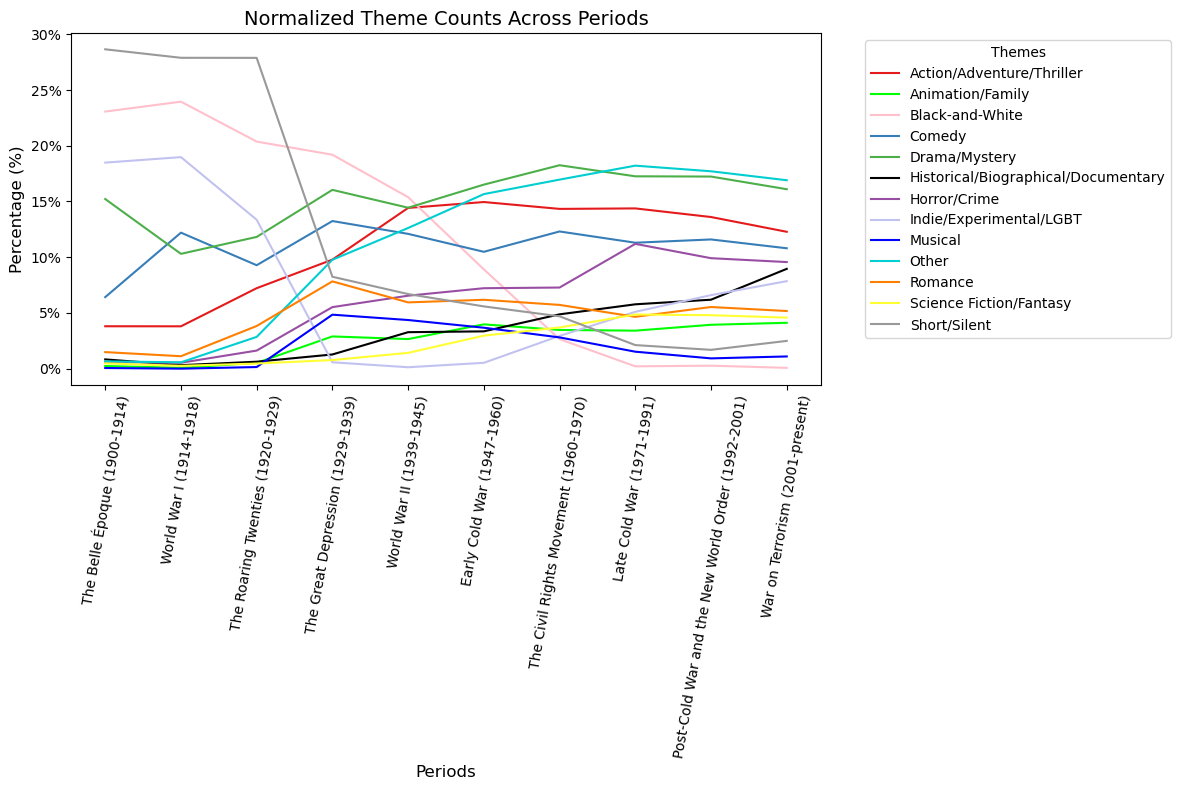

In [346]:
# Create a function to plot normalized theme counts across periods
def create_theme_periods_plot_static(normalized_theme_periods_counts, title):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each theme as a line
    for theme in normalized_theme_periods_counts.columns:
        ax.plot(
            normalized_theme_periods_counts.index,  # Periods on the x-axis
            normalized_theme_periods_counts[theme],  # Normalized counts on the y-axis
            label=theme,  # Theme name for the legend
            color=theme_colors.get(theme, 'gray')  # Theme color
        )

    # Add title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Periods', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

    # Add a legend
    ax.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=80)

    # Adjust layout to display the legend properly
    plt.tight_layout()

    return fig

# Create static plot for the normalized theme counts across periods
fig_theme_periods_static = create_theme_periods_plot_static(
    normalized_theme_periods_counts, 
    "Normalized Theme Counts Across Periods"
)

# Save the static plot as a PNG image
fig_theme_periods_static.savefig('/Users/lilly-flore/Desktop/static_theme_periods_plot.png', dpi=300)

# Show the plot
plt.show()


Interactive stacked bar plot that shows the evolution of movie themes over different periods. It allows users to toggle the visibility of individual themes through a dropdown menu or show all themes at once with a "Show All" button. Each theme is represented by a separate trace, and the plot displays the proportion of movies for each theme per period, with the option to hover over bars to view detailed values.

In [347]:
# Create an empty figure
fig = go.Figure()

# Add each theme as a trace
for theme in normalized_theme_periods_counts.columns:
    fig.add_trace(go.Bar(
        x=normalized_theme_periods_counts.index,
        y=normalized_theme_periods_counts[theme],
        name=theme, 
        marker_color=theme_colors.get(theme, 'gray'),
        hovertemplate='Period: %{x}<br>' + 'Theme proportion: %{y}<br>',
    ))

# Add buttons for hide/show functionality
visibility = [[True if i == idx else False for i in range(len(themes))]
              for idx in range(len(themes))]

# Define "Select Theme" button
select_theme_button = dict(
    label="Select Theme",
    method=None,
    args=[]
)

theme_buttons = [
    dict(
        label=theme,
        method="update",
        args=[
            {"visible": vis},  # Update visibility
            {"title": f"Evolution of {theme} Movies Over the Periods"}  # Update title
        ]
    )
    for theme, vis in zip(themes, visibility)
]


# Combine "Select Theme" and theme-specific buttons
buttons = [select_theme_button] + theme_buttons

# Dropdown menu for individual themes
dropdown_menu = dict(
    type="dropdown",
    buttons=buttons,
    x=1.214,
    xanchor="center",
    y=1.2,
    yanchor="top",
)

# Button for "Show All" placed on the side
side_button = dict(
    type="buttons",
    buttons=[
        dict(
            label="Show All",
            method="update",
            args=[
                {"visible": [True] * len(themes)},
                {"title": "Evolution of Movie Themes Over the Periods"}
            ]
        )
    ],
    x=1.005,  # Adjust position to place on the side
    xanchor="left",
    y=1.3,
    yanchor="middle",
)

fig.update_layout(
    updatemenus=[dropdown_menu, side_button],
    title={
        'text': 'Evolution of Movie Themes Over the Periods',
        'x': 0.5,
        'xanchor': 'right'
    },
    barmode='stack',
    xaxis_title="Period",
    yaxis_title="Proportion of Movies",
    legend_title="Themes",
    height=500,
    width=1000,
)

fig.show()
fig.write_html('/Users/lilly-flore/Desktop/bar_theme_period.html')

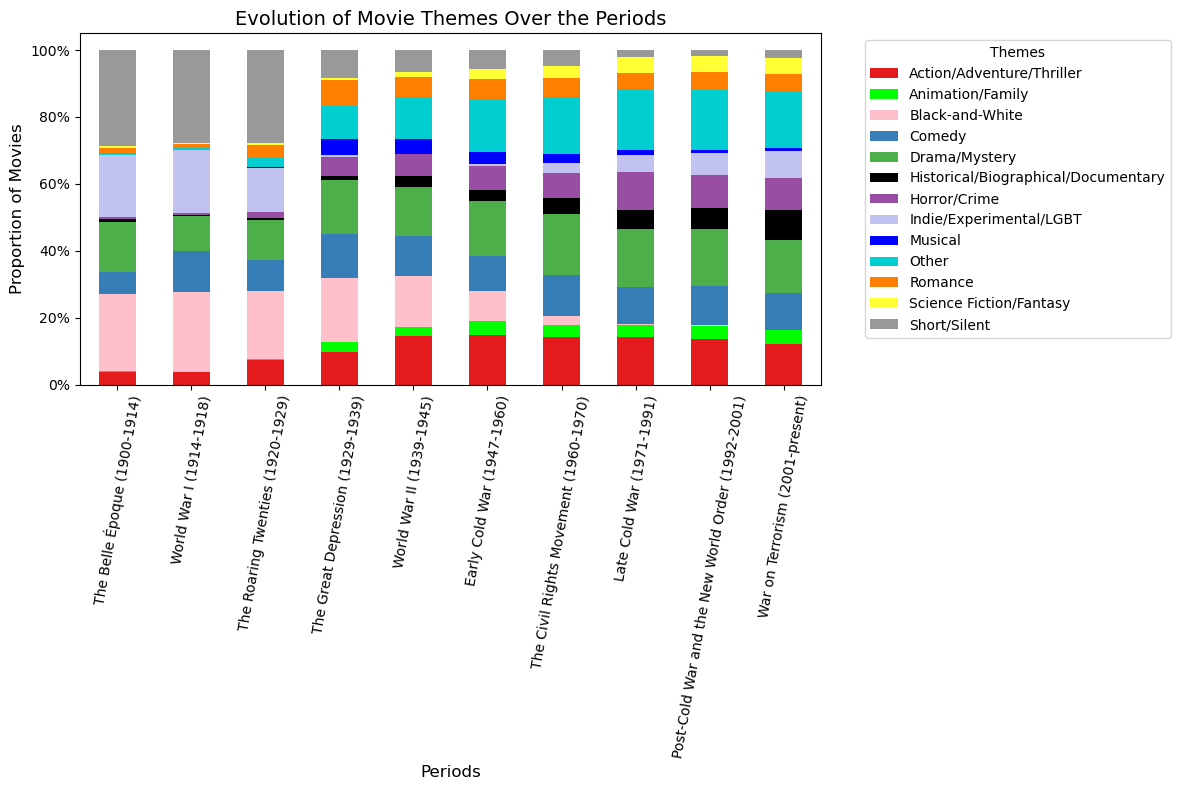

In [348]:
# Create a static bar plot for normalized theme counts across periods
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each theme as a bar
normalized_theme_periods_counts.plot(
    kind='bar', 
    stacked=True,  # To keep the stacked bar chart format
    ax=ax, 
    color=[theme_colors.get(theme, 'gray') for theme in normalized_theme_periods_counts.columns]
)

# Add a title and labels
ax.set_title('Evolution of Movie Themes Over the Periods', fontsize=14)
ax.set_xlabel('Periods', fontsize=12)
ax.set_ylabel('Proportion of Movies', fontsize=12)

# Rotate x-axis labels by 80 degrees
plt.xticks(rotation=80)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Add a legend
ax.legend(title="Themes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout()


# Show the static plot
plt.show()


This interactive heatmap visualizes correlations between periods, highlighting the top 3 themes contributing to each relationship through hover text.

In [349]:
# Transpose the normalized theme periods counts
periods_themes = normalized_theme_periods_counts.T
# Calculate the correlation matrix
correlation_matrix = periods_themes.corr()

# Generate hover text for each cell in the heatmap
hover_text = []
for i in range(len(correlation_matrix)):
    hover_row = []
    for j in range(len(correlation_matrix.columns)):
        top_themes = theme_periods_counts_pivot.columns[periods_themes.iloc[i].argsort()[:3]]  
        hover_row.append(f"Top 3 themes: {', '.join(top_themes)}")
    hover_text.append(hover_row)

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Viridis',
    text=hover_text, 
    hoverinfo='text', 
    colorbar=dict(title="Correlation")
))

# Update layout for better visualization
fig.update_layout(
    title={
        'text': "Interactive Correlation Matrix Between Periods",
        'x': 0.5,
        'xanchor': 'center'
    },
    height=800,
    width=1000,
    xaxis_tickangle=45, 
)

# Display the figure
fig.show()
fig.write_html('/Users/lilly-flore/Desktop/period_corr_matrix.html')


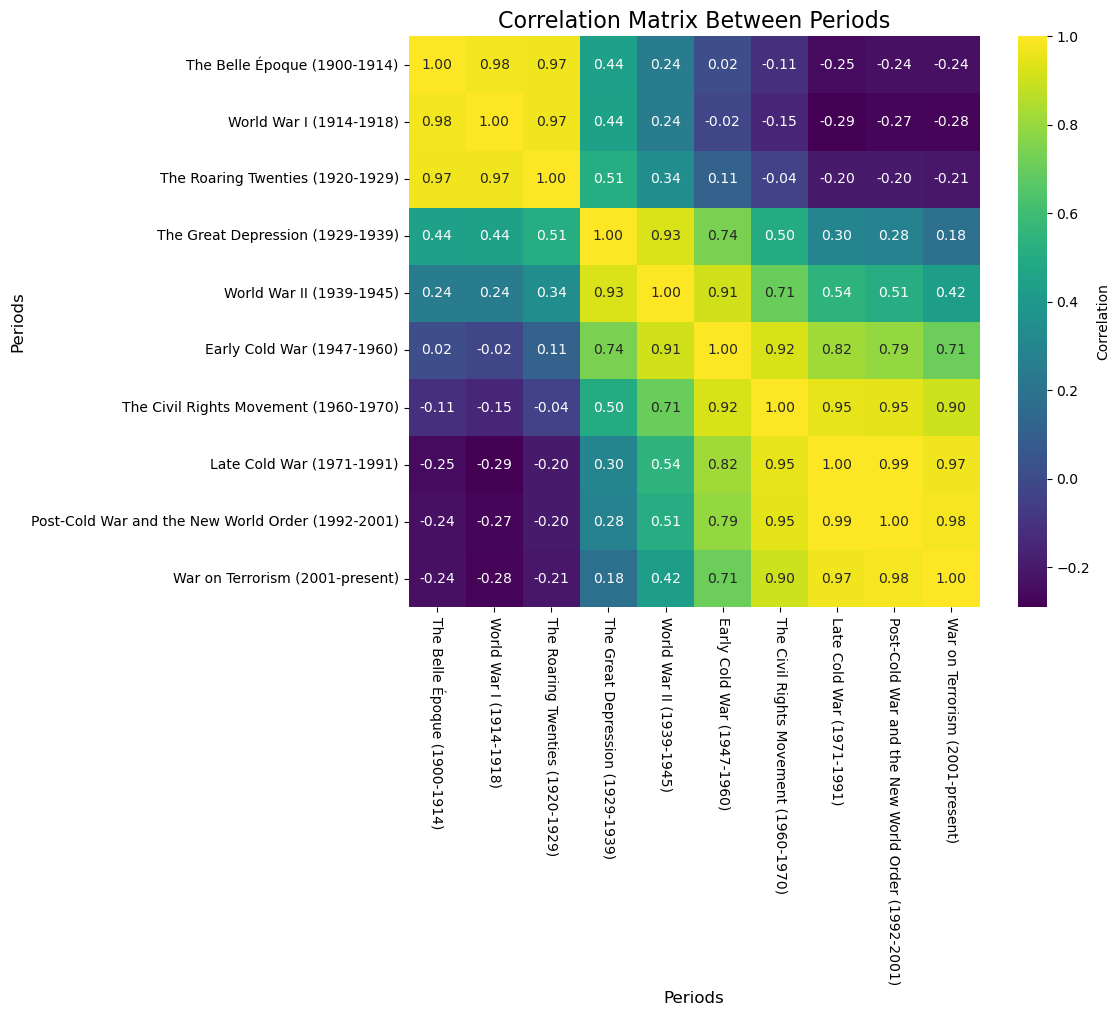

In [350]:
# Transpose the normalized theme periods counts for easier correlation calculation
periods_themes = normalized_theme_periods_counts.T

# Calculate the correlation matrix
correlation_matrix = periods_themes.corr()

# Generate hover-like text by getting the top 3 themes for each period
top_themes = []
for i in range(len(correlation_matrix)):
    row_themes = periods_themes.iloc[i].argsort()[:3]  # Get the top 3 themes for each period
    top_themes.append(', '.join(periods_themes.columns[row_themes]))

# Create the heatmap with seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Annotate cells with the correlation value
    fmt=".2f",  # Display correlation value with 2 decimals
    cmap='viridis', 
    cbar_kws={'label': 'Correlation'},
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.index,
    ax=ax,
    annot_kws={'size': 10},  # Adjust font size for annotations
    square=True  # Keep the heatmap square
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=270)

# Set the title and labels
ax.set_title('Correlation Matrix Between Periods', fontsize=16)
ax.set_xlabel('Periods', fontsize=12)
ax.set_ylabel('Periods', fontsize=12)

# Adjust layout to fit the labels and title
plt.tight_layout()

# Show the static plot
plt.show()

## All plots from here on were used in the website, the explanations of the plots are all in the website

In [351]:
mov = pd.read_csv("data/processed_movies.csv")
# Movies with and without rating
no_rat = mov[mov['averageRating'].isnull() | mov['numVotes'].isnull()]
rat = mov[mov['averageRating'].notnull() & mov['numVotes'].notnull()]

In [352]:
RatingsNbrOfMovies(rat, no_rat)

We can see that there are a lot of movies without rating for years between 1912 and 1918 and later on around 2007. The first peak of missing ratings is quite problematic as there are more movies without rating than with, while the second is much less problematic since there are more movies that have a rating. 
We should take this into account later on when trying to draw conclusions. 

In [353]:
RatingsVsYearsAllPlotly(rat)

In [354]:
RatingsWithErrorBarsPlotly(rat)

/Users/lilly-flore/Desktop/Master-NX/ADA/ada-2024-project-metal2024/src/utilsRatings.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [355]:
pearson_corr_all, spearman_corr_all = computePearsonSpearmanCorr(rat, year=None)
pearson_corr_1973, spearman_corr_1973 = computePearsonSpearmanCorr(rat, year=1973)
print(f"Pearson correlation (all data): {pearson_corr_all}")
print(f"Spearman correlation (all data): {spearman_corr_all}")
print(f"Pearson correlation (1973): {pearson_corr_1973}")
print(f"Spearman correlation (1973): {spearman_corr_1973}")

max_p, max_s, max_y = 0,0,0
min_p, min_s, min_y = 0,0,0

for year in range(1920,2008):
    p,s = computePearsonSpearmanCorr(rat, year=year)
    if (s > max_s):
        max_p,max_s,max_y = p,s,year
    if (s < min_s):
        min_p, min_s, min_y = p,s,year


print(f"Max Pearson correlation ({max_y}): {max_p}")
print(f"Max Spearman correlation ({max_y}): {max_s}")
print(f"Min Pearson correlation ({min_y}): {min_p}")
print(f"Min Spearman correlation ({min_y}): {min_s}")

Pearson correlation (all data): 0.20417286675453206
Spearman correlation (all data): 0.13748496100686738
Pearson correlation (1973): 0.3789457475348088
Spearman correlation (1973): 0.4912244874859843
Max Pearson correlation (1949): 0.4367260611323274
Max Spearman correlation (1949): 0.6310749464411852
Min Pearson correlation (2006): 0.19723496322779946
Min Spearman correlation (2006): -0.07592210951086635


In [356]:

# Plot the correlations with customized colors
plot_correlations(pearson_corr_all, spearman_corr_all, pearson_corr_1973, spearman_corr_1973, max_p, max_s, max_y, min_p, min_s, min_y)

In [357]:
RatingsvsVotesScatterLog(rat, frac=0.2, nolog=True)
RatingsvsVotesScatterLog(rat, frac=0.2, nolog=False)

In [358]:

#To filter for specific years, pass a list of years, for example:
RatingsvsVotesScatterYears(rat, frac=1, years=[1949, 1973, 2006])


In [359]:
periods_map = {
    "The Belle Époque (1900-1914)": {"start_year": 1900, "end_year": 1913},
    "World War I (1914-1918)": {"start_year": 1914, "end_year": 1919},
    "The Roaring Twenties (1920-1929)": {"start_year": 1920, "end_year": 1928},
    "The Great Depression (1929-1939)": {"start_year": 1929, "end_year": 1939},
    "World War II (1939-1945)": {"start_year": 1940, "end_year": 1945},
    "Early Cold War (1946-1960)": {"start_year": 1946, "end_year": 1960},
    "The Civil Rights Movement (1960-1970)": {"start_year": 1961, "end_year": 1970},
    "Late Cold War (1971-1991)": {"start_year": 1971, "end_year": 1991},
    "Post-Cold War (1992-2001)": {"start_year": 1992, "end_year": 2000},
    "War on Terrorism (2001-present)": {"start_year": 2001, "end_year": 2024},
}
# Assign a period label to each movie based on its release year
def assign_period(year):
    for period, bounds in periods_map.items():
        if bounds["start_year"] <= year <= bounds["end_year"]:
            return period
    return None

# Add a 'Period' column to the DataFrame
rat.loc[:, 'Period'] = rat['Movie release date'].apply(assign_period)

/var/folders/tj/z0dp280955b2cclgs13c8ngm0000gn/T/ipykernel_48948/3146210212.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [360]:
# Usage example
avg_rating_per_period, std_rating_per_period, weighted_avg_rating_per_period = compute_average_ratings_per_period(rat)
plot_ratings_per_period(avg_rating_per_period, std_rating_per_period, weighted_avg_rating_per_period, periods_map)

In [361]:
# To filter for specific years, pass a list of years, for example:
RatingsvsVotesScatter(rat, 0.2, ["Early Cold War (1946-1960)","Late Cold War (1971-1991)"], periods_map)

In [362]:
# Clearer to put it this way: theme and its corresponding genres
theme_mapping = {
    'Action/Adventure/Thriller': ['action', 'thriller', 'adventure', 'fantasy adventure', 'action comedy', 'action thrillers', 'spy', 'martial arts film', 'epic', 'road movie', 'action/adventure', 'adventure comedy', 'war film', 'military drama', 'combat film', 'anti-war film', 'political thriller', 'war film', 'military drama', 'combat film', 'western'],
    'Comedy': ['comedy', 'romantic comedy', 'black comedy', 'slapstick', 'comedy-drama', 'comedy film', 'adventure comedy', 'screwball comedy', 'fantasy comedy', 'domestic comedy', 'comedy of manners', 'sex comedy', 'comedy of errors'],
    'Drama/Mystery': ['drama', 'family drama', 'melodrama', 'crime drama', 'political drama', 'comedy-drama', 'marriage drama', 'courtroom drama', 'historical fiction', 'political cinema', 'social issues', 'crime comedy', 'mystery', 'detective', 'detective fiction'],
    'Romance': ['romance film', 'romantic comedy', 'romantic drama', 'romantic fantasy'],
    'Horror/Crime': ['crime fiction', 'crime thriller', 'gangster film', 'detective', 'detective fiction', 'crime drama', 'b-movie', 'heist', 'horror', 'slasher', 'psychological thriller', 'zombie film', 'horror comedy', 'monster movie', 'natural horror films', 'suspense'],
    'Science Fiction/Fantasy': ['science fiction', 'fantasy', 'superhero movie', 'sci-fi horror', 'superhero', 'fantasy comedy'],
    'Animation/Family': ['animation', 'animated cartoon', 'computer animation', 'animated musical', 'family', 'teen', '"children\'s/family"', '"children\'s"', 'family-oriented adventure', "children\'s fantasy"],
    'Historical/Biographical/Documentary': ['documentary', 'docudrama', 'rockumentary', 'concert film', 'mockumentary', 'period piece', 'historical drama', 'biography', 'history', 'biographical film', 'historical fiction'],
    'Short/Silent': ['short film', 'silent film'],
    'Black-and-White': ['black-and-white'], 
    'Independent/Experimental/LGBT': ['indie', 'experimental film', 'lgbt', 'gay', 'gay themed', 'gay interest'],
    'Musical': ['musical', 'musical drama', 'musical comedy'],
    'Other': []
}

# Inverting the theme_mapping to map genres to themes
genre_to_theme_mapping = {
    genre: theme
    for theme, genres in theme_mapping.items()
    for genre in genres
}


# Casefolding all the strings of column "Movie genres" the Data Frame
rat.loc[:,'Movie genres'] = rat['Movie genres'].apply(lambda x: x.casefold() if isinstance(x, str) else x)
# Clean the genres
rat.loc[:,'Movie genres'] = rat['Movie genres'].apply(clean_genres)
# Map Genres
rat.loc[:,'Themes'] = rat['Movie genres'].apply(lambda genres: map_genres_to_themes(genres, genre_to_theme_mapping))


/var/folders/tj/z0dp280955b2cclgs13c8ngm0000gn/T/ipykernel_48948/618855956.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [363]:
# Usage example
# To exclude schindler's list use rat[~rat["Movie name"].str.strip().__eq__("Schindler's List")]
weighted_avg_ratings = compute_weighted_ratings_per_theme_period(rat, periods_map)
plot_weighted_ratings_by_theme(weighted_avg_ratings,weighted_avg_rating_per_period, periods_map,True,showByDefault=['Independent/Experimental/LGBT', 'Black-and-White', 'Short/Silent'])


/Users/lilly-flore/Desktop/Master-NX/ADA/ada-2024-project-metal2024/src/utilsRatings.py:504: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [364]:
# Example Usage
selected_pairs = [
    ("Black-and-White", "Post-Cold War (1992-2001)"),
    ("Independent/Experimental/LGBT", "The Great Depression (1929-1939)")
]
RatingsvsVotesByThemePeriod(rat, selected_pairs, True,frac=1)

In [365]:
weighted_avg_ratings = compute_weighted_ratings_per_theme_period(rat, periods_map)
plot_weighted_ratings_by_theme(weighted_avg_ratings,weighted_avg_rating_per_period, periods_map,False,showByDefault=['Action/Adventure/Thriller', 'Comedy', 'Drama/Mystery'])

/Users/lilly-flore/Desktop/Master-NX/ADA/ada-2024-project-metal2024/src/utilsRatings.py:504: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [366]:
# Example Usage
selected_pairs = [
        ("Comedy", "Late Cold War (1971-1991)")
,
    ("Drama/Mystery", "World War II (1939-1945)")
]

RatingsvsVotesByThemePeriod(rat, selected_pairs, False,frac=1)

In [367]:

# Usage example
RatingsvsVotesByTheme(rat, theme_mapping, showByDefault=["Drama/Mystery","Comedy"], frac=0.1)
